In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
import os
os.chdir('..')
import pandas as pd
import numpy as np
from datetime import timedelta
from src.utils import create_time_series_dataset_fast, clean_and_load
# sys.path.append(os.path.abspath(''))

In [15]:
from src.utils import split_train_val_by_week, normalize_features

### <span style="color: lightskyblue;"> Carga de datos </span>

In [13]:
os.chdir('proyecto_final')

In [3]:
import pandas as pd
print(os.path.abspath('.'))
# hacer cd ..



trips_2020 = clean_and_load('data/raw/trips_2020.csv', drop_cols=['Unnamed: 0'])
trips_2021 = clean_and_load('data/raw/trips_2021.csv', drop_cols=['Unnamed: 0', 'genero'])  # eliminar segunda 'Género'
trips_2022 = clean_and_load('data/raw/trips_2022.csv', drop_cols=['Unnamed: 0', 'X'], rename_cols={'Género': 'genero'})
trips_2023 = clean_and_load('data/raw/trips_2023.csv', drop_cols=['Unnamed: 0'])
trips_2024 = clean_and_load('data/raw/trips_2024.csv')

# trips_2020 = trips_2020[trips_2020['fecha_origen_recorrido'].dt.month > 8]

trips = pd.concat([ trips_2021, trips_2022, trips_2023, trips_2024], ignore_index=True)

trips.to_csv('data/processed/trips.csv', index=False)

c:\Users\Matteo\Documents\Facultad\tercero\primercuatri\ML\ML\PF\proyecto_final


In [4]:

import pandas as pd

# Lista de archivos y si contienen o no la columna del DNI
user_files = [
    ('data/raw/usuarios_ecobici_2020.csv', True),
    ('data/raw/usuarios_ecobici_2021.csv', True),
    ('data/raw/usuarios_ecobici_2022.csv', True),
    ('data/raw/usuarios_ecobici_2023.csv', True),
    ('data/raw/usuarios_ecobici_2024.csv', False),  # este no tiene columna de DNI
]

user_dfs = []

for path, has_dni in user_files:
    df = pd.read_csv(path, parse_dates=['fecha_alta'])
    if has_dni:
        df.drop(columns=['Customer.Has.Dni..Yes...No.'], inplace=True)
    # Normalizar nombres de columnas
    df.columns = df.columns.str.lower().str.replace('.', '_').str.replace(' ', '').str.replace('__', '_')
    df = df.rename(columns={
        'id_usuario': 'id_usuario',
        'genero_usuario': 'genero_usuario',
        'edad_usuario': 'edad_usuario',
        'fecha_alta': 'fecha_alta',
        'hora_alta': 'hora_alta',
    })

    user_dfs.append(df)

# Concatenar todos los usuarios
usuarios = pd.concat(user_dfs, ignore_index=True)

# Convertir id_usuario a string para hacer merge correcto
usuarios['id_usuario'] = usuarios['id_usuario'].astype(float)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_21724\2079243983.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, parse_dates=['fecha_alta'])


In [10]:
# Nos aseguramos que los id_usuario de trips también sean string
trips = pd.read_csv('data/processed/trips.csv')
trips['id_usuario'] = trips['id_usuario'].astype(float)
# usuarios edad entre 10 y 100
# Paso 1: Convertir todo a string
usuarios['edad_usuario'] = usuarios['edad_usuario'].astype(str)

# Paso 2: Eliminar comas, espacios y valores vacíos
usuarios['edad_usuario'] = usuarios['edad_usuario'].str.replace(',', '', regex=False).str.strip()

# Paso 3: Filtrar solo los valores que son dígitos (descarta "NaN", "dos mil", etc.)
usuarios = usuarios[usuarios['edad_usuario'].str.isdigit()]

# Paso 4: Convertir a int
usuarios['edad_usuario'] = usuarios['edad_usuario'].astype(int)

# Paso 5: Filtrar valores fuera del rango 10–100
usuarios = usuarios[(usuarios['edad_usuario'] >= 10) & (usuarios['edad_usuario'] <= 100)]



# Hacemos un left join: cada recorrido se enriquece con datos del usuario
trips_enriched = trips.merge(
    usuarios[['id_usuario', 'edad_usuario', 'fecha_alta', 'hora_alta']],
    on='id_usuario',
    how='left'
)
# trips_2024_filtered = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month <= 8]
# trips_2024_test = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month >= 9]
trips_enriched['fecha_origen_recorrido'] = pd.to_datetime(trips_enriched['fecha_origen_recorrido'])
trips_enriched['fecha_destino_recorrido'] = pd.to_datetime(trips_enriched['fecha_destino_recorrido'])
trips_enriched_train = trips_enriched[((trips_enriched['fecha_destino_recorrido'].dt.month <= 8) & (trips_enriched['fecha_destino_recorrido'].dt.year == 2024)) | (trips_enriched['fecha_destino_recorrido'].dt.year < 2024)]
trips_2024_test = trips_enriched[((trips_enriched['fecha_destino_recorrido'].dt.month >= 9) & (trips_enriched['fecha_destino_recorrido'].dt.year == 2024))]
trips_enriched = trips_enriched_train
trips_enriched_test = trips_2024_test
# df = df.groupby("nombre_estacion_origen").filter(
#     lambda x: x["direccion_estacion_origen"].nunique() > 1
# )
usuarios

C:\Users\Matteo\AppData\Local\Temp\ipykernel_21724\3009524324.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv('data/processed/trips.csv')


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,735944.0,FEMALE,29,2020-12-31,20:19:04
1,735892.0,MALE,44,2020-12-31,11:24:04
2,735873.0,MALE,39,2020-12-31,09:28:27
3,735876.0,MALE,37,2020-12-31,09:49:30
4,735952.0,OTHER,29,2020-12-31,21:07:04
...,...,...,...,...,...
627876,1120417.0,FEMALE,45,2024-03-01,15:09:21
627877,1153589.0,MALE,55,2024-05-08,18:17:14
627878,1216661.0,MALE,25,2024-09-28,09:23:29
627879,1256657.0,MALE,24,2024-11-22,19:38:23


In [11]:
trips_enriched.to_csv('data/processed/trips_enriched.csv', index=False)
trips_2024_test.to_csv('data/processed/trips_2024_test.csv', index=False)

In [41]:
import pandas as pd

trips_enriched = pd.read_csv('data/processed/trips_enriched.csv')
trips_enriched['fecha_origen_recorrido'] = pd.to_datetime(trips_enriched['fecha_origen_recorrido'])
trips_enriched['fecha_destino_recorrido'] = pd.to_datetime(trips_enriched['fecha_destino_recorrido'])
# trips_enriched.to_csv('data/processed/trips_enriched.csv', index=False)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_10060\3023557596.py:3: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_enriched = pd.read_csv('data/processed/trips_enriched.csv')


## <span style="color: lightskyblue;"> 2. Transformación a Series Temporales (30 min) </span>

In [42]:

# Ejecutar transformación
print("Iniciando transformación de trips_enriched a series temporales...")
trips_enriched_ts = create_time_series_dataset_fast(trips_enriched, time_window_minutes=30)

# Guardar resultado
trips_enriched_ts.to_csv('data/processed/trips_enriched_timeseries.csv', index=False)
print(f"\nDataset guardado en: data/processed/trips_enriched_timeseries.csv")

trips_enriched_ts

Iniciando transformación de trips_enriched a series temporales...


C:\Users\Matteo\AppData\Local\Temp\ipykernel_10060\935591261.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_origen_window'] = (trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
C:\Users\Matteo\AppData\Local\Temp\ipykernel_10060\935591261.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_destino_window'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T')
C:\Users\Matteo\AppData\Local\Temp\ipykernel_10060\935591261.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
C:\Users\Matteo\AppData\Local\Temp\ipykernel_10060\935591261.py:26: FutureWarning: 'T' is deprecated and wi

Total de timestamps: 64271
Total de estaciones: 398

Dataset final:
Forma: (25579858, 22)
Rango temporal: 2021-01-01 00:30:00 a 2024-08-31 23:30:00
Estaciones únicas: 398

Dataset guardado en: data/processed/trips_enriched_timeseries.csv


,timestamp,id_estacion,nombre_estacion,direccion_estacion,lat_estacion,long_estacion,despachos_count,duracion_recorrido_mean,duracion_recorrido_std,duracion_recorrido_count,...,proporcion_mujeres_prev_5,arribos_count_prev_5,despachos_count_prev_6,duracion_recorrido_mean_prev_6,duracion_recorrido_std_prev_6,duracion_recorrido_count_prev_6,edad_usuario_mean_prev_6,edad_usuario_std_prev_6,proporcion_mujeres_prev_6,arribos_count_prev_6
13,2021-01-01 00:30:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
411,2021-01-01 01:00:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809,2021-01-01 01:30:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,1,1606.0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1207,2021-01-01 02:00:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1605,2021-01-01 02:30:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25578253,2024-08-31 21:30:00,556.0,230 - AREVALO,Arévalo 1408,-34.583614,-58.443604,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25578651,2024-08-31 22:00:00,556.0,230 - AREVALO,Arévalo 1408,-34.583614,-58.443604,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25579049,2024-08-31 22:30:00,556.0,230 - AREVALO,Arévalo 1408,-34.583614,-58.443604,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25579447,2024-08-31 23:00:00,556.0,230 - AREVALO,Arévalo 1408,-34.583614,-58.443604,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:

import gc

gc.collect()

0

## <span style="color: lightskyblue;"> 3. Split Train/Val y Normalización </span>

In [4]:

# Ejecutar separación y normalización
print("=" * 60)
print("SEPARACIÓN TRAIN/VAL Y NORMALIZACIÓN")
print("=" * 60)
trips_enriched_ts = pd.read_csv('data/processed/trips_enriched_timeseries.csv', parse_dates=['timestamp'])
# 1. Separar train/val
train_raw, val_raw = split_train_val_by_week(trips_enriched_ts, random_seed=42)

# train_raw.to_csv('data/processed/train_raw.csv', index=False)
# val_raw.to_csv('data/processed/val_raw.csv', index=False)


SEPARACIÓN TRAIN/VAL Y NORMALIZACIÓN
Iniciando separación train/val...
Dataset original: (25579858, 70)
Rango temporal: 2021-01-01 00:30:00 a 2024-08-31 23:30:00
Total de semanas únicas: 227
Días seleccionados para validación: 227
Dataset train: (21243250, 70) (83.0%)
Dataset val: (4336608, 70) (17.0%)
✅ Separación correcta: No hay solapamiento de días entre train y val


In [ ]:

# 2. Normalizar features
train_norm, val_norm, scaler, numeric_columns = normalize_features(train_raw, val_raw)

# 3. Guardar resultados
# train_norm.to_csv('data/processed/train_normalized.csv', index=False)
# val_norm.to_csv('data/processed/val_normalized.csv', index=False)

print(f"\n📁 Archivos guardados:")
print(f"   Train: data/processed/train_normalized.csv")
print(f"   Val: data/processed/val_normalized.csv")

# 4. Mostrar estadísticas finales
print(f"\n  Resumen final:")
print(f"   Train: {train_norm.shape[0]:,} filas × {train_norm.shape[1]:,} columnas")
print(f"   Val: {val_norm.shape[0]:,} filas × {val_norm.shape[1]:,} columnas")
print(f"   Proporción val: {len(val_norm)/len(trips_enriched_ts)*100:.1f}%")

# 5. Verificar distribución temporal
print(f"\n📅 Distribución temporal:")
print("Train por mes:")
print(train_norm['timestamp'].dt.month.value_counts().sort_index())
print("\nVal por mes:")
print(val_norm['timestamp'].dt.month.value_counts().sort_index())



Iniciando normalización...
Columnas numéricas a normalizar: 60
Columnas categóricas (no normalizadas): 3
Columnas excluidas: 7
✅ Normalización completada
   Media de features train (debe ser ~0): -0.000000
   Std de features train (debe ser ~1): 1.000000

📁 Archivos guardados:
   Train: data/processed/train_normalized.csv
   Val: data/processed/val_normalized.csv

📊 Resumen final:
   Train: 21,243,250 filas × 70 columnas
   Val: 4,336,608 filas × 70 columnas
   Proporción val: 17.0%

📅 Distribución temporal:
Train por mes:
timestamp
1     1948210
2     1795776
3     1986816
4     1910400
5     1948608
6     1910400
7     1967712
8     1967712
9     1432800
10    1451904
11    1432800
12    1490112
Name: count, dtype: int64

Val por mes:
timestamp
1     420288
2     362976
3     382080
4     382080
5     420288
6     382080
7     401184
8     401184
9     286560
10    324768
11    286560
12    286560
Name: count, dtype: int64


## <span style="color: lightskyblue;"> 5. Entrenamiento XGBoost </span>

In [6]:
import gc
gc.collect()

0

In [7]:
# dropear del train y del val todas las columnas que empiecen con nombre_estacion_ y direccion_estacion_

train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion_') or col.startswith('direccion_estacion_') or col.startswith('modelo_mas_comun_')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion_') or col.startswith('direccion_estacion_') or col.startswith('modelo_mas_comun_')])

In [21]:
# guardar train_df y val_df
train_norm.to_csv('data/processed/train_norm.csv', index=False)
val_norm.to_csv('data/processed/val_norm.csv', index=False)

# Modelo M0

Este es el modelo que vamos a usar para evaluar en test, por que es el unico que se ajusta a la consigna fundamental.

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    # Remover features que contengan '_prev' en el nombre
    feature_cols = [col for col in feature_cols if '_prev' not in col]
    print(feature_cols)
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost para regresión usando distribución de Poisson.
    """
    print("\n  Entrenando modelo XGBoost...")
    xgb_params = {
        'n_estimators': 1000,  # Aumentamos para dar margen al early stopping
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,
        'verbosity': 1,
        'tree_method': 'gpu_hist',  # Cambiar a 'hist' si no tenés GPU
        'eval_metric': 'rmse',  # Métrica a monitorear para early stopping
        'max_bin': 128, 
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=25,
    verbose=True
    )
    print(f"   Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n  Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n  MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
#   PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST\n" + "="*60)

# # drop nombre_estacion: object, direccion_estacion: object, modelo_mas_comun: object
train_raw = train_raw.drop(columns=[col for col in train_raw.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_raw = val_raw.drop(columns=[col for col in val_raw.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_raw, val_raw)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)

# 4. Guardar modelo
print("\n  Guardando modelo...")
model_info = {
    'model': model,
    'features': feature_cols,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': metrics,
    'scaler': scaler
}
with open('data/processed/xgb_model_M0.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("   Modelo guardado en data/processed/xgb_model_M0.pkl")


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y target...
['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
X_train: (21243250, 13), y_train: (21243250,)
X_val: (4336608, 13), y_val: (4336608,)

🚀 Entrenando modelo XGBoost...


c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.95083
[1]	validation_0-rmse:0.93675
[2]	validation_0-rmse:0.92349
[3]	validation_0-rmse:0.91141
[4]	validation_0-rmse:0.90141
[5]	validation_0-rmse:0.89111
[6]	validation_0-rmse:0.88202
[7]	validation_0-rmse:0.87393
[8]	validation_0-rmse:0.86643
[9]	validation_0-rmse:0.85928
[10]	validation_0-rmse:0.85275
[11]	validation_0-rmse:0.84621
[12]	validation_0-rmse:0.84015
[13]	validation_0-rmse:0.83478
[14]	validation_0-rmse:0.82985
[15]	validation_0-rmse:0.82549
[16]	validation_0-rmse:0.82075
[17]	validation_0-rmse:0.81703
[18]	validation_0-rmse:0.81354
[19]	validation_0-rmse:0.80962
[20]	validation_0-rmse:0.80624
[21]	validation_0-rmse:0.80355
[22]	validation_0-rmse:0.80081
[23]	validation_0-rmse:0.79798
[24]	validation_0-rmse:0.79549
[25]	validation_0-rmse:0.79310
[26]	validation_0-rmse:0.79132
[27]	validation_0-rmse:0.78920
[28]	validation_0-rmse:0.78720
[29]	validation_0-rmse:0.78571
[30]	validation_0-rmse:0.78354
[31]	validation_0-rmse:0.78240
[32]	validation_0-


GENERANDO VISUALIZACIONES DE RESULTADOS


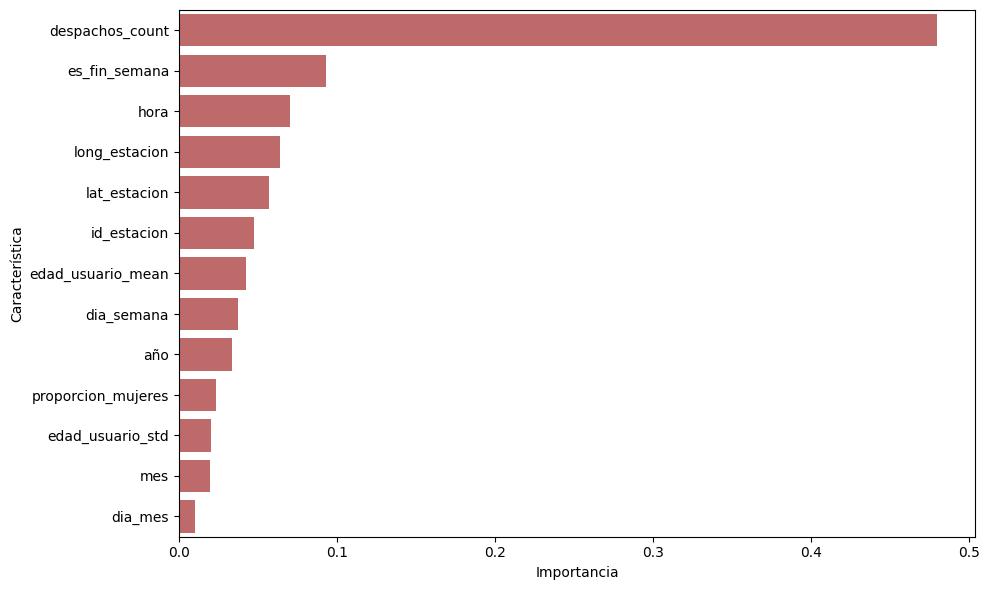

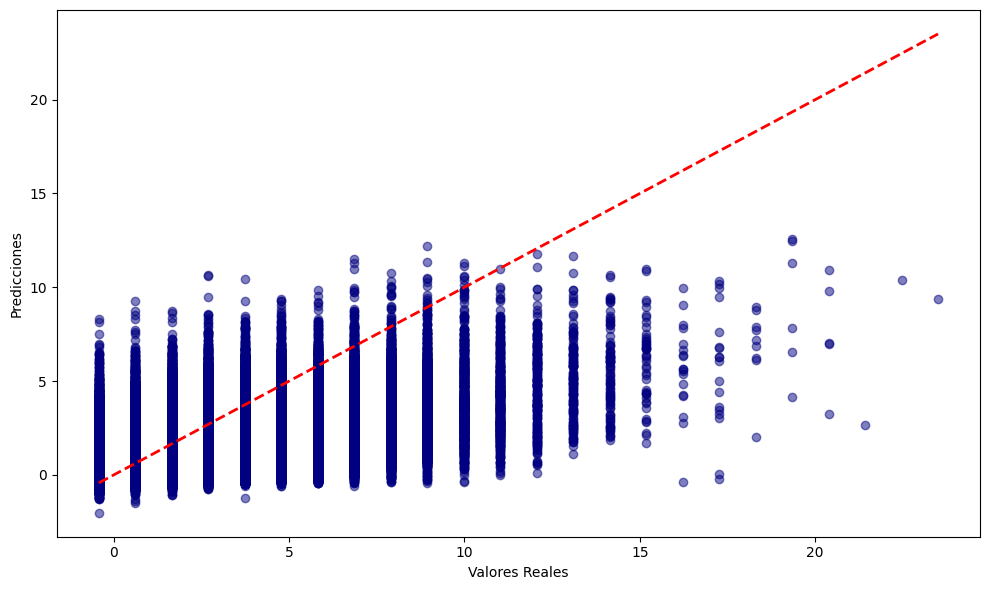


🏆 TOP 5 MEJORES ESTACIONES (R2):
                MSE       MAE        R2
 1.350680  0.822575  0.350678  0.617366
-0.664840  2.889421  1.096183  0.597215
-0.930818  2.067558  0.891894  0.571767
-1.580986  0.507739  0.318449  0.557099
 1.486624  0.041075  0.049594  0.548639

⚠️ TOP 5 PEORES ESTACIONES (R2):
                MSE       MAE            R2
-1.533701  0.008826  0.070761 -2.864125e+30
 0.150825  0.006919  0.065006 -2.245504e+30
-0.322025  0.006483  0.061048 -2.103765e+30
 0.676869  0.004402  0.048130 -1.428434e+30
 0.777350  0.004384  0.048088 -1.422570e+30


In [ ]:
# ================================================================
#   VISUALIZACIÓN DE RESULTADOS
# ================================================================
print("\nGENERANDO VISUALIZACIONES DE RESULTADOS\n" + "="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importancia de características
importancia = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(20), x='importancia', y='caracteristica',color='indianred')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_val_pred, alpha=0.5,color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones') 
plt.tight_layout()
plt.show()

# 4. Métricas por estación
metricas_estacion = pd.DataFrame()
for estacion in val_norm['id_estacion'].unique():
    mask = val_norm['id_estacion'] == estacion
    y_real = y_val[mask]
    y_pred = y_val_pred[mask]
    
    metricas_estacion.loc[estacion, 'MSE'] = mean_squared_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'MAE'] = mean_absolute_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'R2'] = r2_score(y_real, y_pred)

# Top 5 mejores y peores estaciones según R2
print("\n🏆 TOP 5 MEJORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2', ascending=False).head())

print("\n⚠️ TOP 5 PEORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2').head())

In [4]:
train_norm = pd.read_csv('data/processed/train_norm.csv')
val_norm = pd.read_csv('data/processed/val_norm.csv')

# Modelo M1
### Agregar features de intervalos previos y cluster geografico

🔄 Aplicando clustering geográfico a datasets...
📊 Procesando dataset de entrenamiento...
✅ Clusters geográficos creados:
   • Número de clusters: 12
   • Coordenadas únicas procesadas: 392
   • Clusters únicos: 12
   • Distribución de clusters:
cluster_geo
4     2615375
3     2455250
8     2135000
0     2135000
9     1974875
10    1974875
6     1814750
11    1601250
1     1441125
7     1387750
Name: count, dtype: int64


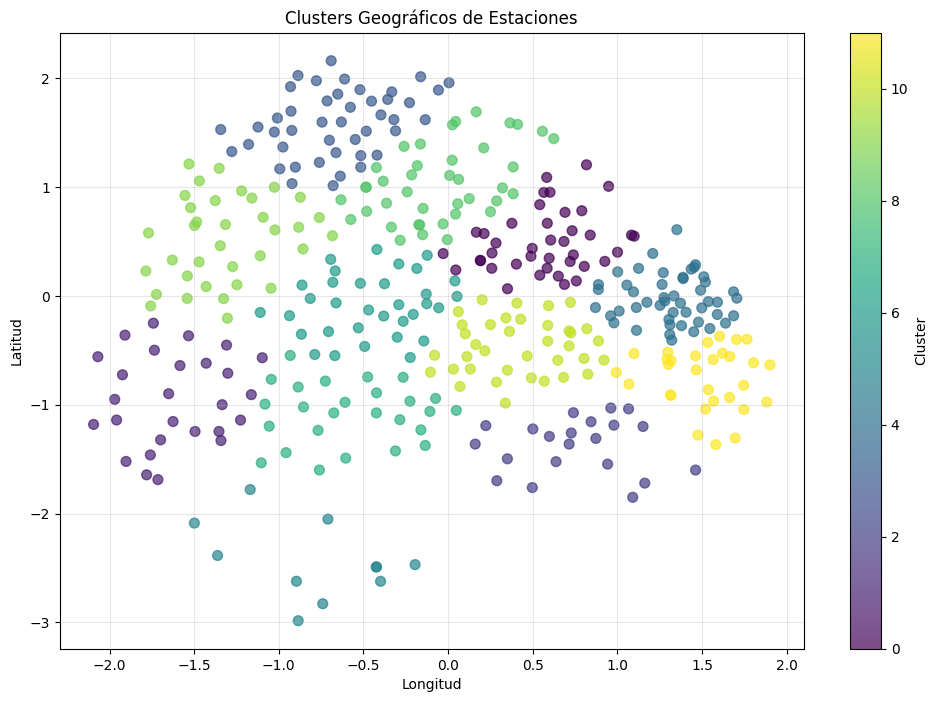

📊 Procesando dataset de validación...
✅ Clusters geográficos creados:
   • Número de clusters: 12
   • Coordenadas únicas procesadas: 392
   • Clusters únicos: 12
   • Distribución de clusters:
cluster_geo
4     533904
3     501216
8     435840
0     435840
9     403152
10    403152
6     370464
11    326880
1     294192
7     283296
Name: count, dtype: int64


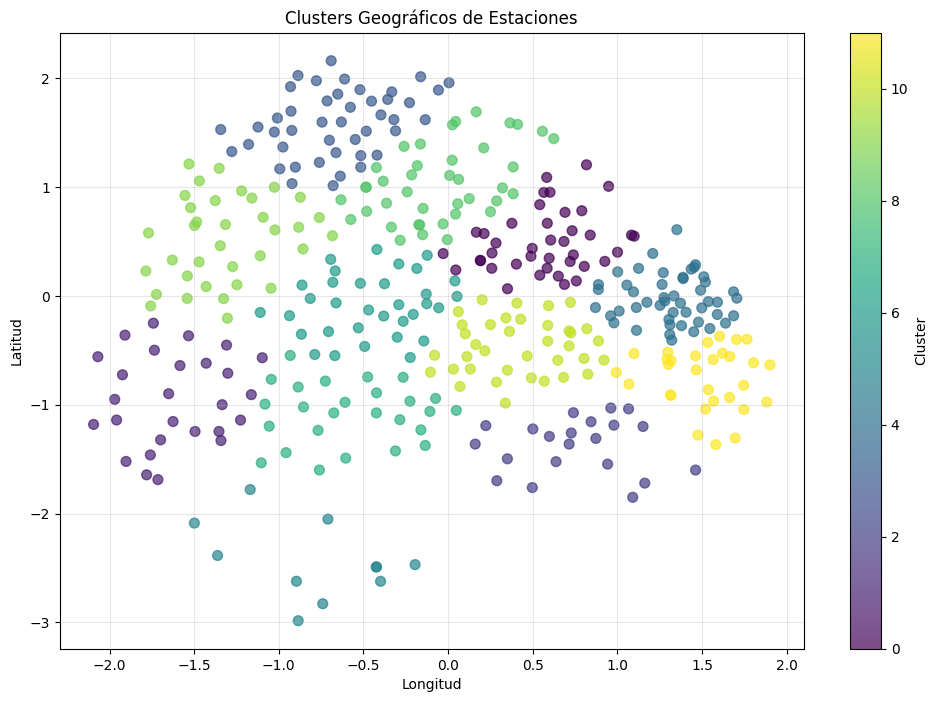


🎯 Análisis de distribución de clusters:
TRAIN - Top 10 clusters más frecuentes:
cluster_geo
4     2615375
3     2455250
8     2135000
0     2135000
9     1974875
10    1974875
6     1814750
11    1601250
1     1441125
7     1387750
Name: count, dtype: int64

VAL - Top 10 clusters más frecuentes:
cluster_geo
4     533904
3     501216
8     435840
0     435840
9     403152
10    403152
6     370464
11    326880
1     294192
7     283296
Name: count, dtype: int64


In [ ]:
# Crear feature cluster_geo usando K-means para clustering geográfico
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Función para crear clusters geográficos
def create_geo_clusters(df, n_clusters=12):
    """
    Crea clusters geográficos basados en coordenadas de estaciones
    
    Args:
        df: DataFrame con columnas lat_estacion y long_estacion
        n_clusters: Número de clusters a crear (default: 12)
    
    Returns:
        DataFrame con nueva columna 'cluster_geo'
    """
    df_clustered = df.copy()
    
    # Extraer coordenadas únicas
    coords = df[['lat_estacion', 'long_estacion']].drop_duplicates().values
    
    # Aplicar K-means a las coordenadas únicas
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(coords)
    
    # Crear mapeo de coordenadas a clusters
    coord_to_cluster = {}
    for i, coord in enumerate(coords):
        cluster_label = kmeans.labels_[i]
        coord_key = (round(coord[0], 6), round(coord[1], 6))  # Redondear para evitar problemas de precisión
        coord_to_cluster[coord_key] = cluster_label
    
    # Asignar clusters a cada fila del dataset
    df_clustered['cluster_geo'] = df.apply(
        lambda row: coord_to_cluster.get(
            (round(row['lat_estacion'], 6), round(row['long_estacion'], 6)), 
            -1  # Cluster -1 para coordenadas no encontradas
        ), axis=1
    )
    
    print(f"   Clusters geográficos creados:")
    print(f"   • Número de clusters: {n_clusters}")
    print(f"   • Coordenadas únicas procesadas: {len(coords)}")
    print(f"   • Clusters únicos: {df_clustered['cluster_geo'].nunique()}")
    print(f"   • Distribución de clusters:")
    print(df_clustered['cluster_geo'].value_counts().head(10))
    
    # Visualizar clusters geográficos
    coords_df = pd.DataFrame(coords, columns=['lat', 'long'])
    coords_df['cluster'] = kmeans.labels_
    
    plt.figure(figsize=(12, 8))
    plt.scatter(coords_df['long'], coords_df['lat'], 
               c=coords_df['cluster'], cmap='viridis', alpha=0.7, s=50)
    plt.title('Clusters Geográficos de Estaciones')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.colorbar(label='Cluster')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return df_clustered, kmeans

# Aplicar clustering a datasets de train y val
print("  Aplicando clustering geográfico a datasets...")

# Verificar que existan las variables train y val
if 'train_norm' in locals() or 'train_norm' in globals():
    print("  Procesando dataset de entrenamiento...")
    train_clustered, kmeans_model = create_geo_clusters(train_norm, n_clusters=12)
    train = train_clustered  # Actualizar train con clusters
    
    print("  Procesando dataset de validación...")
    val_clustered, _ = create_geo_clusters(val_norm, n_clusters=12)
    val = val_clustered  # Actualizar val con clusters
    
    print("\n  Análisis de distribución de clusters:")
    print("TRAIN - Top 10 clusters más frecuentes:")
    print(train['cluster_geo'].value_counts().head(10))
    
    print("\nVAL - Top 10 clusters más frecuentes:")
    print(val['cluster_geo'].value_counts().head(10))
    
else:
    print("❌ Variables 'train' y 'val' no encontradas. Asegúrate de cargar los datasets primero.")


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost para regresión usando distribución de Poisson.
    """
    print("\n  Entrenando modelo XGBoost...")
    xgb_params = {
        'n_estimators': 1000,  # Aumentamos para dar margen al early stopping
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,
        'verbosity': 1,
        'tree_method': 'gpu_hist',  # Cambiar a 'hist' si no tenés GPU
        'eval_metric': 'rmse',  # Métrica a monitorear para early stopping
        'max_bin': 128, 
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=25,
    verbose=True
    )
    print(f"   Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n  Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n  MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
#   PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST\n" + "="*60)

# drop nombre_estacion: object, direccion_estacion: object, modelo_mas_comun: object
train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_norm, val_norm)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)

# 4. Guardar modelo
print("\n  Guardando modelo...")
model_info = {
    'model': model,
    'features': feature_cols,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': metrics
}
with open('data/processed/xgb_model_single_output.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("   Modelo guardado en data/processed/xgb_model_single_output.pkl")


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', 'arribos_coun

c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.09111
[1]	validation_0-rmse:1.06565
[2]	validation_0-rmse:1.04228
[3]	validation_0-rmse:1.02073
[4]	validation_0-rmse:1.00055
[5]	validation_0-rmse:0.98208
[6]	validation_0-rmse:0.96480
[7]	validation_0-rmse:0.94920
[8]	validation_0-rmse:0.93454
[9]	validation_0-rmse:0.92101
[10]	validation_0-rmse:0.90868
[11]	validation_0-rmse:0.89726
[12]	validation_0-rmse:0.88670
[13]	validation_0-rmse:0.87703
[14]	validation_0-rmse:0.86809
[15]	validation_0-rmse:0.85985
[16]	validation_0-rmse:0.85232
[17]	validation_0-rmse:0.84530
[18]	validation_0-rmse:0.83896
[19]	validation_0-rmse:0.83307
[20]	validation_0-rmse:0.82793
[21]	validation_0-rmse:0.82293
[22]	validation_0-rmse:0.81864
[23]	validation_0-rmse:0.81475
[24]	validation_0-rmse:0.81088
[25]	validation_0-rmse:0.80725
[26]	validation_0-rmse:0.80388
[27]	validation_0-rmse:0.80114
[28]	validation_0-rmse:0.79858
[29]	validation_0-rmse:0.79621
[30]	validation_0-rmse:0.79371
[31]	validation_0-rmse:0.79174
[32]	validation_0-


GENERANDO VISUALIZACIONES DE RESULTADOS


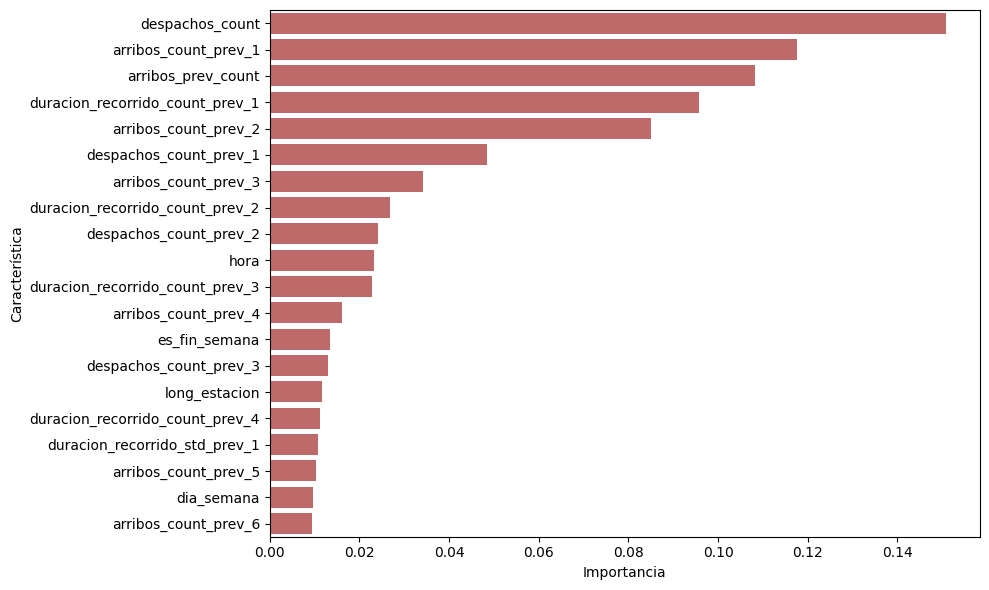

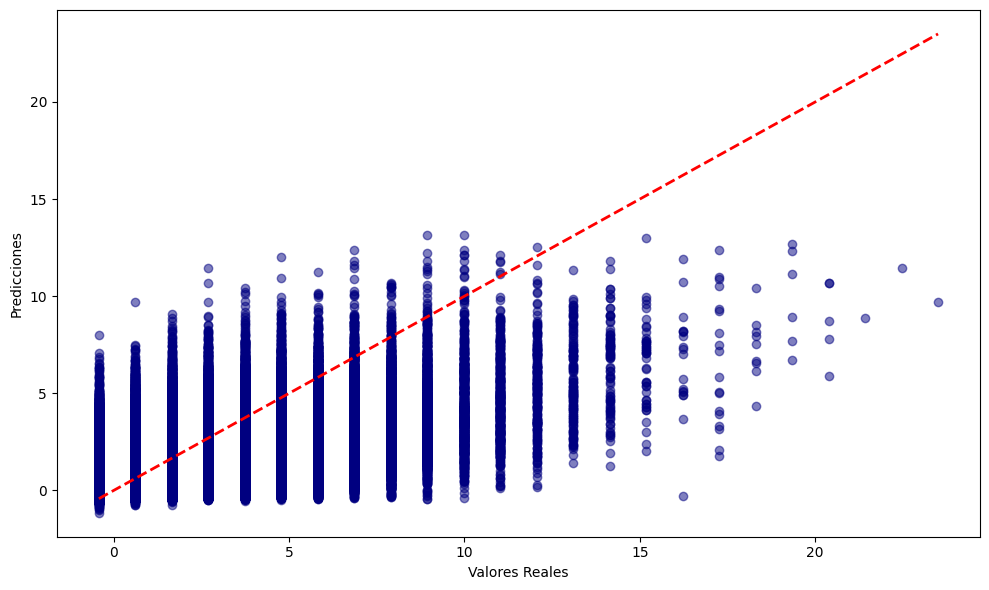


🏆 TOP 5 MEJORES ESTACIONES (R2):
                MSE       MAE        R2
 1.350680  0.744644  0.308023  0.653617
-0.664840  2.573707  1.036086  0.641226
-0.930818  1.920873  0.861525  0.602148
 1.344769  0.679224  0.282672  0.590226
-1.580986  0.472511  0.282646  0.587829

⚠️ TOP 5 PEORES ESTACIONES (R2):
               MSE       MAE         R2
0.292679  0.001953  0.031839 -18.669286
1.569372  0.000364  0.012794  -2.666930
1.533909  0.000649  0.014609  -1.179032
0.942847  0.002532  0.026681  -0.963595
1.587104  0.000534  0.011516  -0.794470


In [ ]:
# ================================================================
#   VISUALIZACIÓN DE RESULTADOS
# ================================================================
print("\nGENERANDO VISUALIZACIONES DE RESULTADOS\n" + "="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importancia de características
importancia = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(20), x='importancia', y='caracteristica',color='indianred')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_val_pred, alpha=0.5,color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones') 
plt.tight_layout()
plt.show()

# 4. Métricas por estación
metricas_estacion = pd.DataFrame()
for estacion in val_norm['id_estacion'].unique():
    mask = val_norm['id_estacion'] == estacion
    y_real = y_val[mask]
    y_pred = y_val_pred[mask]
    
    metricas_estacion.loc[estacion, 'MSE'] = mean_squared_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'MAE'] = mean_absolute_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'R2'] = r2_score(y_real, y_pred)

# Top 5 mejores y peores estaciones según R2
print("\n🏆 TOP 5 MEJORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2', ascending=False).head())

print("\n⚠️ TOP 5 PEORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2').head())

# Modelo M2

### XGBoost con Loss de Poisson

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    # Chequeo de no-negatividad
    assert (y_train >= 0).all(), "y_train contiene valores negativos, Poisson no lo soporta."
    assert (y_val >= 0).all(), "y_val contiene valores negativos, Poisson no lo soporta."
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost para regresión usando Poisson como función de pérdida.
    """
    print("\n  Entrenando modelo XGBoost con pérdida Poisson...")

    xgb_params = {
        'n_estimators': 1500,
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,
        'verbosity': 1,
        'tree_method': 'gpu_hist',  # Cambiar a 'hist' si no tenés GPU
        'eval_metric': 'rmse',
        'max_bin': 128,
        'objective': 'count:poisson',  # <= CAMBIO CLAVE
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=25,
        verbose=True
    )
    print(f"   Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n  Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n  MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
#   PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST CON POISSON\n" + "="*60)

# drop columnas innecesarias
train_raw = train_raw.drop(columns=[col for col in train_raw.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_raw = val_raw.drop(columns=[col for col in val_raw.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_raw, val_raw)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)

# 4. Guardar modelo
print("\n  Guardando modelo...")
model_info = {
    'model': model,
    'features': feature_cols,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': metrics
}
with open('data/processed/xgb_model_poisson.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("   Modelo guardado en data/processed/xgb_model_poisson.pkl")


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST CON POISSON
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', '

c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.95678
[1]	validation_0-rmse:0.94792
[2]	validation_0-rmse:0.93950
[3]	validation_0-rmse:0.93148
[4]	validation_0-rmse:0.92364
[5]	validation_0-rmse:0.91620
[6]	validation_0-rmse:0.90892
[7]	validation_0-rmse:0.90210
[8]	validation_0-rmse:0.89541
[9]	validation_0-rmse:0.88899
[10]	validation_0-rmse:0.88288
[11]	validation_0-rmse:0.87698
[12]	validation_0-rmse:0.87129
[13]	validation_0-rmse:0.86587
[14]	validation_0-rmse:0.86060
[15]	validation_0-rmse:0.85554
[16]	validation_0-rmse:0.85071
[17]	validation_0-rmse:0.84608
[18]	validation_0-rmse:0.84161
[19]	validation_0-rmse:0.83732
[20]	validation_0-rmse:0.83331
[21]	validation_0-rmse:0.82937
[22]	validation_0-rmse:0.82570
[23]	validation_0-rmse:0.82221
[24]	validation_0-rmse:0.81868
[25]	validation_0-rmse:0.81530
[26]	validation_0-rmse:0.81205
[27]	validation_0-rmse:0.80909
[28]	validation_0-rmse:0.80623
[29]	validation_0-rmse:0.80349
[30]	validation_0-rmse:0.80072
[31]	validation_0-rmse:0.79820
[32]	validation_0-

In [ ]:
##   Filtrado de Intervalos Inactivos para Datos Normalizados

print("  FILTRADO PARA DATOS NORMALIZADOS")
print("="*50)

import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Cargar datos normalizados
train_norm = pd.read_csv('data/processed/train_norm.csv')
val_norm = pd.read_csv('data/processed/val_norm.csv')

# Función para preparar features
def prepare_features_and_target_normalized(train_df, val_df):
    feature_cols = [col for col in train_df.columns if col not in 
                   ['timestamp', 'arribos_count', 'duracion_recorrido_mean', 
                    'duracion_recorrido_std', 'duracion_recorrido_count']]
    
    # Solo columnas numéricas
    X_train = train_df[feature_cols].select_dtypes(include=[np.number])
    X_val = val_df[feature_cols].select_dtypes(include=[np.number])
    y_train = train_df['arribos_count']
    y_val = val_df['arribos_count']
    
    print(f"Features: {X_train.shape[1]}, Train: {X_train.shape}, Val: {X_val.shape}")
    return X_train, y_train, X_val, y_val

# Preparar datos
X_train_full, y_train_full, X_val_full, y_val_full = prepare_features_and_target_normalized(train_norm, val_norm)

print(f"\nEstadísticas normalizadas:")
print(f"despachos_count - Media: {X_train_full['despachos_count'].mean():.4f}")
print(f"arribos_count - Media: {y_train_full.mean():.4f}")

# Para datos normalizados, usar percentiles bajos como "inactivos"
PERCENTIL = 10  # Filtrar 10% menos activo

desp_thresh = X_train_full['despachos_count'].quantile(PERCENTIL/100)
arr_thresh = pd.Series(y_train_full).quantile(PERCENTIL/100)

print(f"\nThresholds (percentil {PERCENTIL}%):")
print(f"Despachos <= {desp_thresh:.4f}")
print(f"Arribos <= {arr_thresh:.4f}")

# Filtrar filas donde AMBAS están en percentil bajo
train_inactive = ((X_train_full['despachos_count'] <= desp_thresh) & 
                  (y_train_full <= arr_thresh))
val_inactive = ((X_val_full['despachos_count'] <= desp_thresh) & 
                (y_val_full <= arr_thresh))

inactive_count = train_inactive.sum()
print(f"\nFilas inactivas: {inactive_count:,} ({(inactive_count/len(X_train_full)*100):.2f}%)")

if inactive_count > 1000:
    # Aplicar filtro
    X_train_active = X_train_full[~train_inactive]
    y_train_active = y_train_full[~train_inactive]
    X_val_active = X_val_full[~val_inactive]
    y_val_active = y_val_full[~val_inactive]
    
    print(f"\nDatos filtrados:")
    print(f"Train: {X_train_active.shape} (eliminadas: {len(X_train_full)-len(X_train_active):,})")
    print(f"Val: {X_val_active.shape} (eliminadas: {len(X_val_full)-len(X_val_active):,})")
    
    # Entrenar XGBoost
    print(f"\n  Entrenando XGBoost...")
    
    xgb_model = xgb.XGBRegressor(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        random_state=42, n_jobs=4, tree_method='hist'
    )
    
    start_time = time.time()
    xgb_model.fit(X_train_active, y_train_active,
                  eval_set=[(X_val_active, y_val_active)],
                  early_stopping_rounds=50, verbose=False)
    
    print(f"   Completado en {time.time()-start_time:.1f}s")
    
    # Evaluación
    y_val_pred = xgb_model.predict(X_val_active)
    val_r2 = r2_score(y_val_active, y_val_pred)
    val_mse = mean_squared_error(y_val_active, y_val_pred)
    
    print(f"\n  RESULTADOS:")
    print(f"R² Validación: {val_r2:.4f}")
    print(f"MSE Validación: {val_mse:.4f}")
    
    reduction_pct = (1 - len(X_train_active)/len(X_train_full)) * 100
    print(f"Reducción dataset: {reduction_pct:.2f}%")
    print(f"Mejora media arribos: {((y_train_active.mean()/y_train_full.mean()-1)*100):.1f}%")
    
    # Guardar modelo
    import pickle
    model_info = {
        'model': xgb_model,
        'filter_percentile': PERCENTIL,
        'reduction_pct': reduction_pct,
        'val_r2': val_r2
    }
    
    with open('data/processed/xgb_normalized_filtered.pkl', 'wb') as f:
        pickle.dump(model_info, f)
    
    print(f"\n  Modelo guardado: xgb_normalized_filtered.pkl")
    
else:
    print(f"\nInsuficientes filas para filtrar. Intenta percentil más alto.")



GENERANDO VISUALIZACIONES DE RESULTADOS


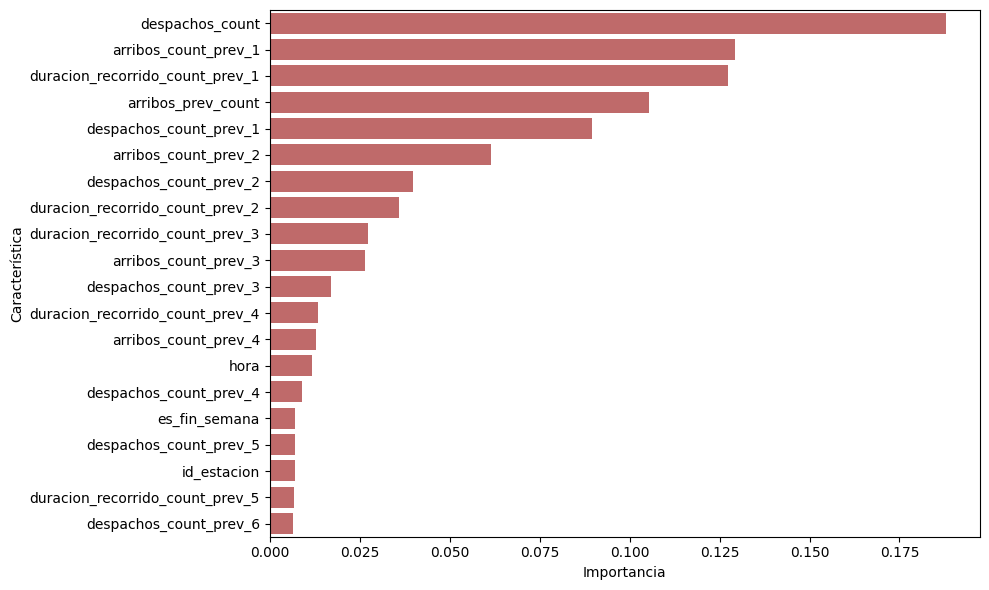

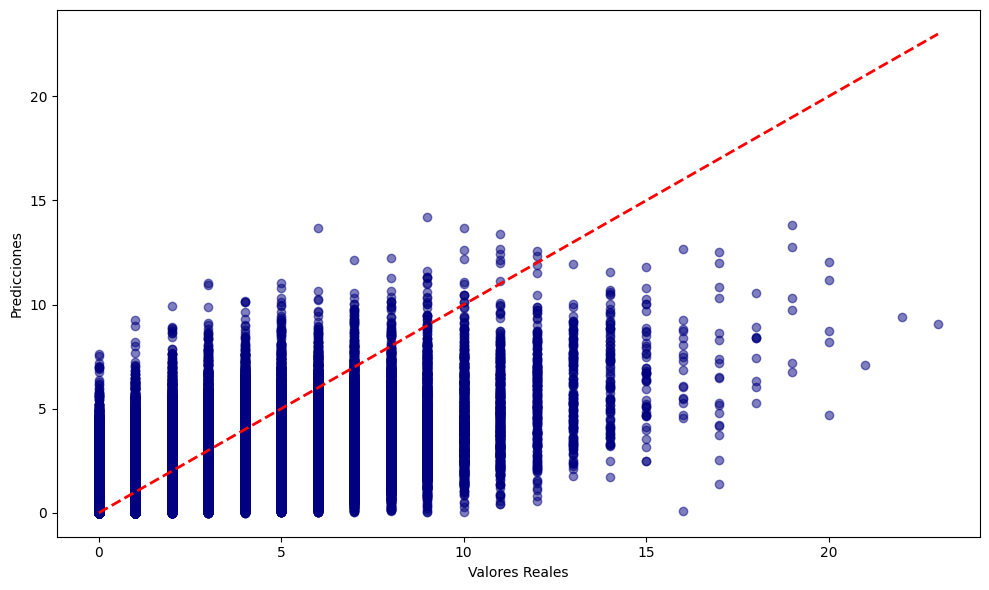


🏆 TOP 5 MEJORES ESTACIONES (R2):
          MSE       MAE        R2
516  0.686715  0.284219  0.654411
175  2.365131  0.988477  0.643309
539  0.032486  0.018464  0.613799
130  1.758180  0.818987  0.606032
20   0.431698  0.251890  0.592600

⚠️ TOP 5 PEORES ESTACIONES (R2):
          MSE       MAE        R2
337  0.000495  0.016861 -4.398119
547  0.000287  0.001103 -0.044232
447  0.001231  0.006914 -0.032938
541  0.009423  0.004121 -0.016930
105  0.002224  0.009167 -0.011446


In [ ]:
# ================================================================
#   VISUALIZACIÓN DE RESULTADOS
# ================================================================
print("\nGENERANDO VISUALIZACIONES DE RESULTADOS\n" + "="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importancia de características
importancia = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(20), x='importancia', y='caracteristica',color='indianred')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_val_pred, alpha=0.5,color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones') 
plt.tight_layout()
plt.show()

# 4. Métricas por estación
metricas_estacion = pd.DataFrame()
for estacion in val_raw['id_estacion'].unique():
    mask = val_raw['id_estacion'] == estacion
    y_real = y_val[mask]
    y_pred = y_val_pred[mask]
    
    metricas_estacion.loc[estacion, 'MSE'] = mean_squared_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'MAE'] = mean_absolute_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'R2'] = r2_score(y_real, y_pred)

# Top 5 mejores y peores estaciones según R2
print("\n🏆 TOP 5 MEJORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2', ascending=False).head())

print("\n⚠️ TOP 5 PEORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2').head())

#### Otras opciones:
# LightGBM

In [ ]:

##   Modelo LightGBM

# Entrenar modelo LightGBM con train_norm y val_norm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

print("  ENTRENANDO MODELO LIGHTGBM")
print("="*60)

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    # Chequeo de no-negatividad
    # assert (y_train >= 0).all(), "y_train contiene valores negativos, Poisson no lo soporta."
    # assert (y_val >= 0).all(), "y_val contiene valores negativos, Poisson no lo soporta."
    
    return X_train, y_train, X_val, y_val, feature_cols
# Preparar datos usando la función existente (sin MultiOutput)
X_train_lgb, y_train_lgb, X_val_lgb, y_val_lgb, feature_cols_lgb = prepare_features_and_target(train_norm, val_norm)

# Configuración de LightGBM
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 42,
    'n_estimators': 1000,
    'device': 'gpu'  # Cambiar a 'cpu' si no tienes GPU
}

print("  Configuración LightGBM:")
for param, value in lgb_params.items():
    print(f"  {param}: {value}")

print(f"\n   Dimensiones de datos:")
print(f"  X_train: {X_train_lgb.shape}")
print(f"  y_train: {y_train_lgb.shape}")
print(f"  X_val: {X_val_lgb.shape}")
print(f"  y_val: {y_val_lgb.shape}")

# Crear modelo LightGBM (regresión simple, no MultiOutput)
lgb_model = lgb.LGBMRegressor(**lgb_params)

print(f"\n  Iniciando entrenamiento...")
start_time = time.time()

# Entrenar el modelo
lgb_model.fit(X_train_lgb, y_train_lgb)

training_time = time.time() - start_time
print(f"   Entrenamiento completado en {training_time:.2f} segundos")

# Evaluación
print(f"\n  EVALUANDO MODELO LIGHTGBM...")

# Predicciones
y_train_pred_lgb = lgb_model.predict(X_train_lgb)
y_val_pred_lgb = lgb_model.predict(X_val_lgb)

# Métricas
train_mse_lgb = mean_squared_error(y_train_lgb, y_train_pred_lgb)
train_mae_lgb = mean_absolute_error(y_train_lgb, y_train_pred_lgb)
train_r2_lgb = r2_score(y_train_lgb, y_train_pred_lgb)

val_mse_lgb = mean_squared_error(y_val_lgb, y_val_pred_lgb)
val_mae_lgb = mean_absolute_error(y_val_lgb, y_val_pred_lgb)
val_r2_lgb = r2_score(y_val_lgb, y_val_pred_lgb)

print(f"\n  RESULTADOS LIGHTGBM:")
print(f"{'Conjunto':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
print("-" * 50)
print(f"{'Train':<12} {train_mse_lgb:<12.4f} {train_mae_lgb:<12.4f} {train_r2_lgb:<12.4f}")
print(f"{'Validación':<12} {val_mse_lgb:<12.4f} {val_mae_lgb:<12.4f} {val_r2_lgb:<12.4f}")

# Análisis de overfitting
overfitting_mse_lgb = (train_mse_lgb - val_mse_lgb) / val_mse_lgb * 100
overfitting_mae_lgb = (train_mae_lgb - val_mae_lgb) / val_mae_lgb * 100

print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
print(f"Diferencia MSE: {overfitting_mse_lgb:.2f}% ({'Overfitting' if overfitting_mse_lgb < -10 else 'OK'})")
print(f"Diferencia MAE: {overfitting_mae_lgb:.2f}% ({'Overfitting' if overfitting_mae_lgb < -10 else 'OK'})")

# Análisis de feature importance
print(f"\n  TOP 15 FEATURES MÁS IMPORTANTES:")
feature_importance = lgb_model.feature_importances_
feature_names = X_train_lgb.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(importance_df.head(15).iterrows()):
    print(f"  {i+1:2d}. {row['feature'][:40]:<40} {row['importance']:.4f}")

print(f"\n   LIGHTGBM COMPLETADO - R² en validación: {val_r2_lgb:.4f}")

🔄 ENTRENANDO MODELO LIGHTGBM
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', 'arribos_count_prev_3', 'des

#### Otras opciones:
# Red Neuronal

In [ ]:

# Entrenar una red neuronal con train_norm y val_norm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler

print(" ENTRENANDO RED NEURONAL")
print("="*60)

# Preparar datos usando la función existente (regresión simple)
X_train_nn, y_train_nn, X_val_nn, y_val_nn, feature_cols_nn = prepare_features_and_target(train_norm, val_norm)

print(f" Dimensiones de datos:")
print(f"  X_train: {X_train_nn.shape}")
print(f"  y_train: {y_train_nn.shape}")
print(f"  X_val: {X_val_nn.shape}")
print(f"  y_val: {y_val_nn.shape}")

# Definir arquitectura de la red neuronal (regresión simple)
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.3):
        super(SimpleMLP, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Capas ocultas
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Capa de salida (una sola neurona para regresión)
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x).squeeze(-1)  # Remover la última dimensión

# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_nn.values)
y_train_tensor = torch.FloatTensor(y_train_nn.values)
X_val_tensor = torch.FloatTensor(X_val_nn.values)
y_val_tensor = torch.FloatTensor(y_val_nn.values)

# Configuración del modelo
input_size = X_train_nn.shape[1]
hidden_sizes = [512, 256, 128]  # Capas ocultas
batch_size = 256
learning_rate = 0.001
num_epochs = 50

print(f" Arquitectura de la Red:")
print(f"  Input size: {input_size}")
print(f"  Hidden layers: {hidden_sizes}")
print(f"  Output size: 1 (regresión simple)")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")

# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Inicializar modelo, loss y optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Usando dispositivo: {device}")

model_nn = SimpleMLP(input_size, hidden_sizes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"\n Iniciando entrenamiento...")
start_time = time.time()

# Listas para guardar pérdidas
train_losses = []
val_losses = []

# Entrenamiento
for epoch in range(num_epochs):
    # Entrenamiento
    model_nn.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model_nn(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validación
    model_nn.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model_nn(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    # Calcular pérdidas promedio
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Learning rate scheduler
    scheduler.step(avg_val_loss)
    
    # Imprimir progreso cada 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

training_time = time.time() - start_time
print(f"   Entrenamiento completado en {training_time:.2f} segundos")

# Evaluación final
print(f"\n  EVALUANDO RED NEURONAL...")

model_nn.eval()
with torch.no_grad():
    # Predicciones en train
    X_train_tensor = X_train_tensor.to(device)
    y_train_pred_nn = model_nn(X_train_tensor).cpu().numpy()
    
    # Predicciones en validación
    X_val_tensor = X_val_tensor.to(device)
    y_val_pred_nn = model_nn(X_val_tensor).cpu().numpy()

# Convertir a numpy para métricas
y_train_true = y_train_nn.values
y_val_true = y_val_nn.values

# Métricas
train_mse_nn = mean_squared_error(y_train_true, y_train_pred_nn)
train_mae_nn = mean_absolute_error(y_train_true, y_train_pred_nn)
train_r2_nn = r2_score(y_train_true, y_train_pred_nn)

val_mse_nn = mean_squared_error(y_val_true, y_val_pred_nn)
val_mae_nn = mean_absolute_error(y_val_true, y_val_pred_nn)
val_r2_nn = r2_score(y_val_true, y_val_pred_nn)

print(f"\n  RESULTADOS RED NEURONAL:")
print(f"{'Conjunto':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
print("-" * 50)
print(f"{'Train':<12} {train_mse_nn:<12.4f} {train_mae_nn:<12.4f} {train_r2_nn:<12.4f}")
print(f"{'Validación':<12} {val_mse_nn:<12.4f} {val_mae_nn:<12.4f} {val_r2_nn:<12.4f}")

# Análisis de overfitting
overfitting_mse_nn = (train_mse_nn - val_mse_nn) / val_mse_nn * 100
overfitting_mae_nn = (train_mae_nn - val_mae_nn) / val_mae_nn * 100

print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
print(f"Diferencia MSE: {overfitting_mse_nn:.2f}% ({'Overfitting' if overfitting_mse_nn < -10 else 'OK'})")
print(f"Diferencia MAE: {overfitting_mae_nn:.2f}% ({'Overfitting' if overfitting_mae_nn < -10 else 'OK'})")

print(f"\n   RED NEURONAL COMPLETADA - R² en validación: {val_r2_nn:.4f}")

🔄 ENTRENANDO RED NEURONAL
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', 'arribos_count_prev_3', 'despac

KeyboardInterrupt: 

In [22]:
import gc
gc.collect()

0

# Simplificación del Problema 
## Entrenar XGBoost solo para una ventana

In [ ]:
##   XGBoost para Una Estación Específica

# Entrenar modelo XGBoost solo para una estación específica
import xgboost as xgb
import pandas as pd
import numpy as np

print("  ENTRENANDO XGBOOST PARA UNA ESTACIÓN ESPECÍFICA")
print("="*60)

# Preparar datos usando la función existente (regresión simple)
X_train_single, y_train_single, X_val_single, y_val_single, feature_cols_single = prepare_features_and_target(train_norm, val_norm)


for i in range(30):
    # Seleccionar la estación con más arribos para el análisis
    # Agrupar por estación y calcular total de arribos
    train_by_station = X_train_single.groupby('id_estacion')['id_estacion'].count()
    station_counts = train_by_station.sort_values(ascending=False)
    target_station_id = station_counts.index[i]  # Estación con más registros

    print(f"  Estación seleccionada: {target_station_id}")
    print(f"   Total registros en train: {station_counts.iloc[0]:.0f}")

    # Filtrar datos solo para esta estación
    mask_train = X_train_single['id_estacion'] == target_station_id
    mask_val = X_val_single['id_estacion'] == target_station_id

    X_train_station = X_train_single[mask_train]
    y_train_station = y_train_single[mask_train]
    X_val_station = X_val_single[mask_val]
    y_val_station = y_val_single[mask_val]

    print(f"\n   Dimensiones de datos para estación {target_station_id}:")
    print(f"  X_train (estación): {X_train_station.shape}")
    print(f"  y_train (estación): {y_train_station.shape}")
    print(f"  X_val (estación): {X_val_station.shape}")
    print(f"  y_val (estación): {y_val_station.shape}")

    # Estadísticas de la estación seleccionada
    print(f"\n  Estadísticas de la estación {target_station_id}:")
    print(f"  Train - Media: {y_train_station.mean():.2f}, Std: {y_train_station.std():.2f}")
    print(f"  Train - Min: {y_train_station.min():.0f}, Max: {y_train_station.max():.0f}")
    print(f"  Val - Media: {y_val_station.mean():.2f}, Std: {y_val_station.std():.2f}")
    print(f"  Val - Min: {y_val_station.min():.0f}, Max: {y_val_station.max():.0f}")

    # Configuración específica de XGBoost para una sola estación
    xgb_single_params = {
        'n_estimators': 500,          
        'max_depth': 8,                
        'learning_rate': 0.05,        
        'subsample': 0.8,              
        'colsample_bytree': 0.8,       
        'random_state': 42,            
        'n_jobs': 8,                  
        'verbosity': 1,                
        'tree_method': 'gpu_hist', 
        'eval_metric': 'rmse',
        'early_stopping_rounds': 50
    }

    print(f"\n🔧 Configuración XGBoost (estación específica):")
    for param, value in xgb_single_params.items():
        print(f"  {param}: {value}")

    # Crear el modelo XGBoost
    xgb_single_model = xgb.XGBRegressor(**xgb_single_params)

    print(f"\n  Iniciando entrenamiento...")
    start_time = time.time()

    # Entrenar con early stopping
    xgb_single_model.fit(
        X_train_station, y_train_station,
        eval_set=[(X_val_station, y_val_station)],
        verbose=False
    )

    training_time = time.time() - start_time
    print(f"   Entrenamiento completado en {training_time:.2f} segundos")
    print(f"  Mejor iteración: {xgb_single_model.best_iteration}")
    print(f"  Score en validación: {xgb_single_model.best_score:.4f}")

    # Evaluación
    print(f"\n  EVALUANDO MODELO PARA ESTACIÓN {target_station_id}...")

    # Predicciones
    y_train_pred_single = xgb_single_model.predict(X_train_station)
    y_val_pred_single = xgb_single_model.predict(X_val_station)

    # Métricas
    train_mse_single = mean_squared_error(y_train_station, y_train_pred_single)
    train_mae_single = mean_absolute_error(y_train_station, y_train_pred_single)
    train_r2_single = r2_score(y_train_station, y_train_pred_single)

    val_mse_single = mean_squared_error(y_val_station, y_val_pred_single)
    val_mae_single = mean_absolute_error(y_val_station, y_val_pred_single)
    val_r2_single = r2_score(y_val_station, y_val_pred_single)

    print(f"\n  RESULTADOS XGBOOST ESTACIÓN {target_station_id}:")
    print(f"{'Conjunto':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
    print("-" * 50)
    print(f"{'Train':<12} {train_mse_single:<12.4f} {train_mae_single:<12.4f} {train_r2_single:<12.4f}")
    print(f"{'Validación':<12} {val_mse_single:<12.4f} {val_mae_single:<12.4f} {val_r2_single:<12.4f}")

    # Análisis de overfitting
    overfitting_mse_single = (train_mse_single - val_mse_single) / val_mse_single * 100
    overfitting_mae_single = (train_mae_single - val_mae_single) / val_mae_single * 100

    print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
    print(f"Diferencia MSE: {overfitting_mse_single:.2f}% ({'Overfitting' if overfitting_mse_single < -10 else 'OK'})")
    print(f"Diferencia MAE: {overfitting_mae_single:.2f}% ({'Overfitting' if overfitting_mae_single < -10 else 'OK'})")

    # Análisis de feature importance
    print(f"\n  TOP 15 FEATURES MÁS IMPORTANTES:")
    feature_importance = xgb_single_model.feature_importances_
    feature_names = X_train_station.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    for i, (_, row) in enumerate(importance_df.head(15).iterrows()):
        print(f"  {i+1:2d}. {row['feature'][:40]:<40} {row['importance']:.4f}")

    # Análisis de predicciones
    print(f"\n  ANÁLISIS DE PREDICCIONES:")
    print(f"  Predicción promedio (train): {y_train_pred_single.mean():.2f}")
    print(f"  Predicción promedio (val): {y_val_pred_single.mean():.2f}")
    print(f"  Real promedio (train): {y_train_station.mean():.2f}")
    print(f"  Real promedio (val): {y_val_station.mean():.2f}")

    # Análisis de residuos
    residuals_train = y_train_station - y_train_pred_single
    residuals_val = y_val_station - y_val_pred_single

    print(f"\n   ANÁLISIS DE RESIDUOS:")
    print(f"  Train - Media: {residuals_train.mean():.4f}, Std: {residuals_train.std():.4f}")
    print(f"  Val - Media: {residuals_val.mean():.4f}, Std: {residuals_val.std():.4f}")

    print(f"\n   XGBOOST ESTACIÓN ESPECÍFICA COMPLETADO - R² en validación: {val_r2_single:.4f}")

    # Guardar modelo específico
    import pickle
    single_station_model_info = {
        'model': xgb_single_model,
        'station_id': target_station_id,
        'target_column': 'arribos_count',
        'feature_columns': list(X_train_station.columns),
        'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'metrics': {
            'val_mse': val_mse_single,
            'val_mae': val_mae_single, 
            'val_r2': val_r2_single
        },
        'feature_importance': importance_df.to_dict()
    }

    with open(f'data/processed/xgb_single_station_{target_station_id}.pkl', 'wb') as f:
        pickle.dump(single_station_model_info, f)

    print(f"  Modelo guardado en: data/processed/xgb_single_station_{target_station_id}.pkl")


🔄 ENTRENANDO XGBOOST PARA UNA ESTACIÓN ESPECÍFICA
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', 'arribo

In [5]:
train_norm = pd.read_csv('data/processed/train_norm.csv')
val_norm = pd.read_csv('data/processed/val_norm.csv')

## Entrenar XGBoost con Filtrado de Intervalos Activos

#### Filtrar dataset eliminando filas con 0 salidas Y 0 arribos
#### Esto nos deja solo con los intervalos de tiempo más activos

In [ ]:
##   Filtrado de Intervalos Inactivos para Datos Normalizados

print("  FILTRADO PARA DATOS NORMALIZADOS")
print("="*50)

import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Cargar datos normalizados
# train_norm = pd.read_csv('data/processed/train_norm.csv')
# val_norm = pd.read_csv('data/processed/val_norm.csv')

# Función para preparar features
def prepare_features_and_target_normalized(train_df, val_df):
    feature_cols = [col for col in train_df.columns if col not in 
                   ['timestamp', 'arribos_count', 'duracion_recorrido_mean', 
                    'duracion_recorrido_std', 'duracion_recorrido_count']]
    
    # Solo columnas numéricas
    X_train = train_df[feature_cols].select_dtypes(include=[np.number])
    X_val = val_df[feature_cols].select_dtypes(include=[np.number])
    y_train = train_df['arribos_count']
    y_val = val_df['arribos_count']
    
    print(f"Features: {X_train.shape[1]}, Train: {X_train.shape}, Val: {X_val.shape}")
    return X_train, y_train, X_val, y_val

# Preparar datos
X_train_full, y_train_full, X_val_full, y_val_full = prepare_features_and_target_normalized(train_norm, val_norm)

print(f"\nEstadísticas normalizadas:")
print(f"despachos_count - Media: {X_train_full['despachos_count'].mean():.4f}")
print(f"arribos_count - Media: {y_train_full.mean():.4f}")

# Para datos normalizados, usar percentiles bajos como "inactivos"
PERCENTIL = 10  # Filtrar 10% menos activo

desp_thresh = X_train_full['despachos_count'].quantile(PERCENTIL/100)
arr_thresh = pd.Series(y_train_full).quantile(PERCENTIL/100)

print(f"\nThresholds (percentil {PERCENTIL}%):")
print(f"Despachos <= {desp_thresh:.4f}")
print(f"Arribos <= {arr_thresh:.4f}")

# Filtrar filas donde AMBAS están en percentil bajo
train_inactive = ((X_train_full['despachos_count'] <= desp_thresh) & 
                  (y_train_full <= arr_thresh))
val_inactive = ((X_val_full['despachos_count'] <= desp_thresh) & 
                (y_val_full <= arr_thresh))

inactive_count = train_inactive.sum()
print(f"\nFilas inactivas: {inactive_count:,} ({(inactive_count/len(X_train_full)*100):.2f}%)")

if inactive_count > 1000:
    # Aplicar filtro
    X_train_active = X_train_full[~train_inactive]
    y_train_active = y_train_full[~train_inactive]
    X_val_active = X_val_full[~val_inactive]
    y_val_active = y_val_full[~val_inactive]
    
    print(f"\nDatos filtrados:")
    print(f"Train: {X_train_active.shape} (eliminadas: {len(X_train_full)-len(X_train_active):,})")
    print(f"Val: {X_val_active.shape} (eliminadas: {len(X_val_full)-len(X_val_active):,})")
    
    # Entrenar XGBoost
    print(f"\n  Entrenando XGBoost...")
    
    xgb_model = xgb.XGBRegressor(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        random_state=42, n_jobs=4, tree_method='hist'
    )
    
    start_time = time.time()
    xgb_model.fit(X_train_active, y_train_active,
                  eval_set=[(X_val_active, y_val_active)],
                  early_stopping_rounds=50, verbose=False)
    
    print(f"   Completado en {time.time()-start_time:.1f}s")
    
    # Evaluación
    y_val_pred = xgb_model.predict(X_val_active)
    val_r2 = r2_score(y_val_active, y_val_pred)
    val_mse = mean_squared_error(y_val_active, y_val_pred)
    
    print(f"\n  RESULTADOS:")
    print(f"R² Validación: {val_r2:.4f}")
    print(f"MSE Validación: {val_mse:.4f}")
    
    reduction_pct = (1 - len(X_train_active)/len(X_train_full)) * 100
    print(f"Reducción dataset: {reduction_pct:.2f}%")
    print(f"Mejora media arribos: {((y_train_active.mean()/y_train_full.mean()-1)*100):.1f}%")
    
    # Guardar modelo
    import pickle
    model_info = {
        'model': xgb_model,
        'filter_percentile': PERCENTIL,
        'reduction_pct': reduction_pct,
        'val_r2': val_r2
    }
    
    with open('data/processed/xgb_normalized_filtered.pkl', 'wb') as f:
        pickle.dump(model_info, f)
    
    print(f"\n  Modelo guardado: xgb_normalized_filtered.pkl")
    
else:
    print(f"\nInsuficientes filas para filtrar. Intenta percentil más alto.")

🎯 FILTRADO PARA DATOS NORMALIZADOS
Features: 62, Train: (21243250, 62), Val: (4336608, 62)

Estadísticas normalizadas:
despachos_count - Media: -0.0000
arribos_count - Media: 0.0000

Thresholds (percentil 10%):
Despachos <= -0.4146
Arribos <= -0.4219

Filas inactivas: 14,303,839 (67.33%)

Datos filtrados:
Train: (6939411, 62) (eliminadas: 14,303,839)
Val: (1411446, 62) (eliminadas: 2,925,162)

🚀 Entrenando XGBoost...


c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


✅ Completado en 217.9s

📈 RESULTADOS:
R² Validación: 0.3333
MSE Validación: 1.2967
Reducción dataset: 67.33%
Mejora media arribos: 227929596848787008.0%

💾 Modelo guardado: xgb_normalized_filtered.pkl


# Evaluación en Dataset de Test

In [ ]:
import pandas as pd
from src.utils import clean_and_load
test_path = 'data/test/test_data_bicis.csv'
usuarios_path = 'data/raw/usuarios_ecobici_2024.csv'
# ===========================
# 1 Cargar el test
# ===========================
test_raw = pd.read_csv(test_path, parse_dates=['fecha_origen_recorrido', 'fecha_destino_recorrido'])

# ===========================
# 2 Enriquecer con usuarios
# ===========================
usuarios = pd.read_csv(usuarios_path) 
usuarios['id_usuario'] = usuarios['id_usuario'].astype(float)
test_raw['id_usuario'] = test_raw['id_usuario'].astype(float)

test_enriched = test_raw.merge(
    usuarios[['id_usuario', 'edad_usuario', 'fecha_alta', 'hora_alta']],
    on='id_usuario',
    how='left'
)

# ===========================
# 3 Aplicar el pipeline de series temporales
# ===========================
print("Aplicando pipeline temporal...")
test_ts = create_time_series_dataset_fast(test_enriched, time_window_minutes=30)

features_finales = [
    'timestamp','id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count',
    'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres',
    'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año','arribos_count'
    # y opcionalmente las columnas previas:
    # 'despachos_count_prev_1', ..., 'arribos_count_prev_6', etc.
]

test_final = test_ts[features_finales].copy()

test_final.to_csv('data/processed/test_ready_for_predict.csv', index=False)

print("   Test listo para predict con shape:", test_final.shape)
print(test_final.head())


Aplicando pipeline temporal...
Total de timestamps: 116
Total de estaciones: 370


c:\Users\Matteo\Documents\Facultad\tercero\primercuatri\ML\ML\PF\proyecto_final\src\utils.py:216: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_origen_window'] = (trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
c:\Users\Matteo\Documents\Facultad\tercero\primercuatri\ML\ML\PF\proyecto_final\src\utils.py:218: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_destino_window'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T')
c:\Users\Matteo\Documents\Facultad\tercero\primercuatri\ML\ML\PF\proyecto_final\src\utils.py:220: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
c:\Users\Matteo\D


Dataset final:
Forma: (42920, 22)
Rango temporal: 2024-09-09 00:30:00 a 2024-09-11 10:00:00
Estaciones únicas: 370
✅ Test listo para predict con shape: (42920, 15)
               timestamp  id_estacion  lat_estacion  long_estacion  \
192  2024-09-09 00:30:00            2    -34.592424      -58.37471   
562  2024-09-09 01:00:00            2    -34.592424      -58.37471   
932  2024-09-09 01:30:00            2    -34.592424      -58.37471   
1302 2024-09-09 02:00:00            2    -34.592424      -58.37471   
1672 2024-09-09 02:30:00            2    -34.592424      -58.37471   

      despachos_count  edad_usuario_mean  edad_usuario_std  \
192                 0                0.0               0.0   
562                 0                0.0               0.0   
932                 0                0.0               0.0   
1302                0                0.0               0.0   
1672                0                0.0               0.0   

      proporcion_mujeres  hora  dia_seman

In [ ]:
import pickle
import pandas as pd

with open('data/processed/xgb_model_M0.pkl', 'rb') as f:
    model_info = pickle.load(f)

test_final = pd.read_csv('data/processed/test_ready_for_predict.csv')
feature_cols = model_info['features']

X_test = test_final[feature_cols]

print("   Test listo para evaluación con shape:", X_test.shape)
model = model_info['model']
y_test_pred = model.predict(X_test)

submission = pd.DataFrame({
    'id_estacion': test_final['id_estacion'],
    'timestamp': test_final['timestamp'],
    'arribos_predichos': y_test_pred
})

submission.to_csv('data/test/predicciones_test_m0.csv', index=False)
print("   Predicciones guardadas en data/output/predicciones_test_m0.csv")


✅ Test listo para evaluación con shape: (42920, 13)
✅ Predicciones guardadas en data/output/predicciones_test_m0.csv



📊 MÉTRICAS EN TEST
MSE: 0.6161
MAE: 0.4762
R^2: 0.1911


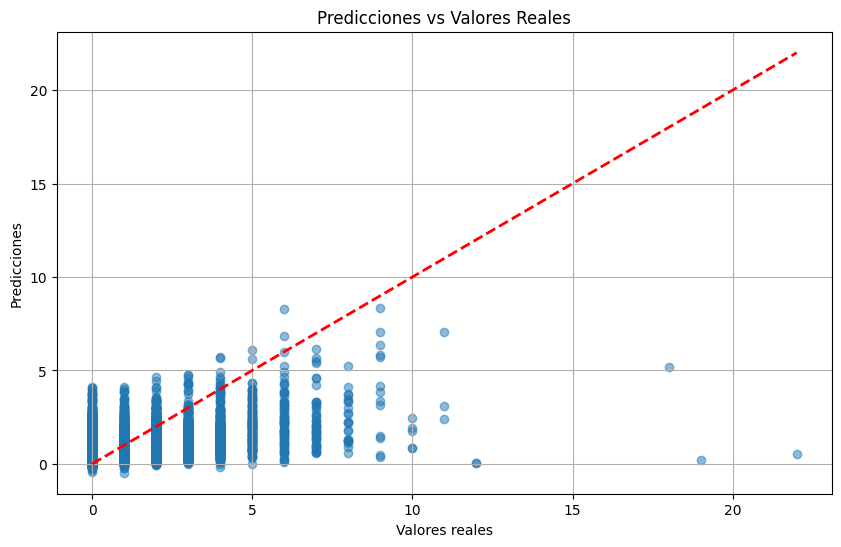

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_true = test_final['arribos_count']
mse = mean_squared_error(y_test_true, y_test_pred)
mae = mean_absolute_error(y_test_true, y_test_pred)
r2 = r2_score(y_test_true, y_test_pred)

print(f"\n  MÉTRICAS EN TEST")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(y_test_true, y_test_pred, alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.grid(True)
plt.show()



In [ ]:
import pandas as pd

test_final['timestamp'] = pd.to_datetime(test_final['timestamp'])

# Lista de timestamps solicitados
fechas_requeridas = pd.to_datetime([
    '2024-09-09 12:00:00',
    '2024-09-09 13:00:00',
    '2024-09-09 14:00:00',
    '2024-09-09 15:00:00',
    '2024-09-09 16:00:00',
    '2024-09-09 17:00:00',
    '2024-09-09 18:00:00',
])

test_filtrado = test_final[test_final['timestamp'].isin(fechas_requeridas)].copy()
print(f"   Filtrado test con shape: {test_filtrado.shape}")


✅ Filtrado test con shape: (2590, 15)


In [ ]:
X_test = test_filtrado[feature_cols]
y_test_pred = model.predict(X_test)

submission = pd.DataFrame({
    'id_estacion': test_filtrado['id_estacion'],
    'timestamp': test_filtrado['timestamp'],
    'arribos_predichos': y_test_pred
})

submission.to_csv('Musacchio_Demarco_ModelM0_30min_predictions.csv', index=False)
print("   Predicciones guardadas en Musacchio_Demarco_ModelM0_30min_predictions.csv")


✅ Predicciones guardadas en Musacchio_Demarco_ModelM0_30min_predictions.csv


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_real = test_filtrado['arribos_count']

metrics_test = {
    'mse': mean_squared_error(y_test_real, y_test_pred),
    'mae': mean_absolute_error(y_test_real, y_test_pred),
    'r2': r2_score(y_test_real, y_test_pred),
}

# Guardar métricas
metrics_df = pd.DataFrame([metrics_test])
metrics_df.to_csv('Musacchio_Demarco_test_metrics.csv', index=False)
print("   Métricas guardadas en Musacchio_Demarco_test_metrics.csv")
print(metrics_df)


✅ Métricas guardadas en Musacchio_Demarco_test_metrics.csv
        mse       mae        r2
0  2.043635  0.949538  0.269266
